## Assignment A5: Signal Representation

### John Mays (jkm100)

In [1]:
# Αα,Ββ,Γγ,Δδ,Εε,Ζζ,Ηη,Θθ,Ιι,Κκ,Λλ,Μμ,Νν,Ξξ,Οο,Ππ,Ρρ,Σσ/ς,Ττ,Υυ,Φφ,Χχ,Ψψ,Ωω
purples = ["#0a0612", "#392249", "#482980", "#673ab7",
           "#7a52aa", "#9779bd", "#b59fd0", "#d3c5e3"];

In [2]:
using Plots
using Random, Distributions
using LinearAlgebra
using DSP
using FFTW
using Images

In [3]:
include("464-A4-jkm100.jl")
include("464-A5-jkm100.jl")

make2Dcell (generic function with 1 method)

### 1. Basis functions of the discrete Fourier transform

#### 1a. Visualizing the Complex Representation of a Fourier Basis

I couldn't exactly tell what you wanted, so if you specify a frequency k it'll plot that.  Otherwise, it will plot $N$ vectors for $k = 0 \dots N-1$.

##### Partial Re-creation of Fig. 4.1 from Prandoni & Vetterli:

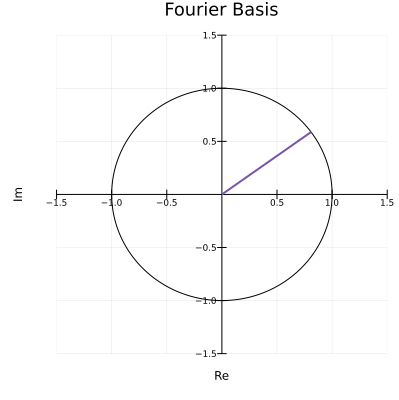

In [4]:
plotfourierbasis(100, k=10)

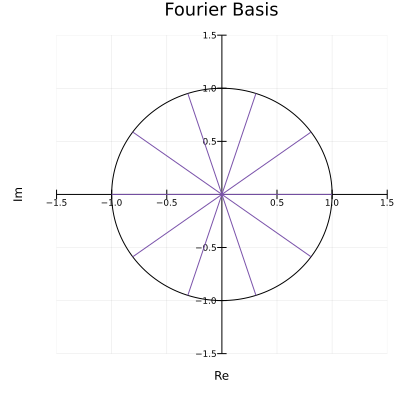

In [5]:
plotfourierbasis(10)

The lines in the complex plane represent the frequencies which are going to be multiplied by coeffiecients to reconstruct the input signal.

#### 1b. Visualizing the basis functions

In [6]:
w(1, 4, 1000)

0.9996841892832999 + 0.02513009544333748im

##### Re-creation of Fig. 4.5 from Prandoni & Vetterli: *Basis Vector $w^{31}\in \mathbb{C}^{32}$*

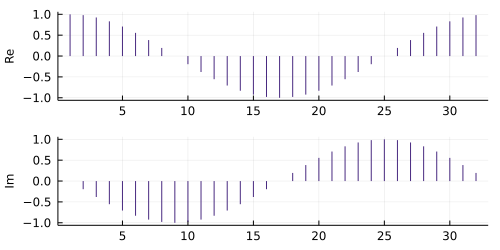

In [8]:
plotw(31, 32)

#### 1c. Orthogonality

Here are the plots of two different basis vectors ($k=1$ and $k=2$)

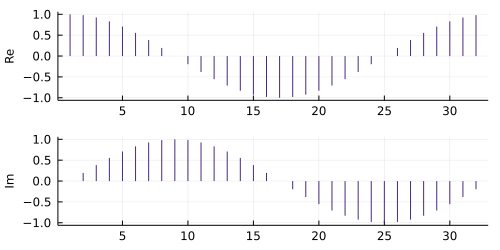

In [9]:
plotw(1, 32)

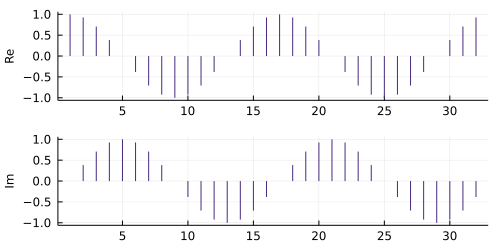

In [10]:
plotw(2, 32)

I can recreate the bases made inside of the plotting functions here:

In [11]:
N = 32
w1 = zeros(ComplexF64,N)
for n = 0:(N-1)
    w1[n+1] = w(n, 1, N)
end
w2 = zeros(ComplexF64,N)
for n = 0:(N-1)
    w2[n+1] = w(n, 2, N)
end

And if I take the two bases' inner (dot) product $\langle w^{1},  w^{2} \rangle =  w^{1} \cdot w^{2}$, it should be zero if they are orthogonal.

In [12]:
println(dot(w1, w2))

-1.6022378597616245e-15 + 2.8847096981041696e-16im


And it is.  Nearly zero on the order of *Float64* precision.  Orthonormativity would require the extra condition that the two bases be normal vectors (having 2-norm of 1).  Do they?

In [13]:
println(norm(w1, 2))
println(norm(w2, 2))

5.656854249492381
5.656854249492381


No, they don't.  Their norms are not 1.  Therefore they are orthogonal, just not orthonormal.  Looking at the plots and realizing that every basis vector is just a frequency multiple of $w^{1}$ (with the same norm), this property should be mutual among the entire set of basis vectors.

### 2. Fourier analysis in matrix-vector form

#### 2a.  Constructing the basis matrix

In [15]:
display(round.(fourier_matrix(5), digits=5))

5×5 Matrix{ComplexF64}:
 1.0+0.0im       1.0+0.0im           1.0+0.0im      …       1.0+0.0im
 1.0+0.0im   0.30902+0.95106im  -0.80902+0.58779im      0.30902-0.95106im
 1.0+0.0im  -0.80902+0.58779im   0.30902-0.95106im     -0.80902-0.58779im
 1.0+0.0im  -0.80902-0.58779im   0.30902+0.95106im     -0.80902+0.58779im
 1.0+0.0im   0.30902-0.95106im  -0.80902-0.58779im      0.30902+0.95106im

#### 2b. Fourier matrix properties

When I take the conjugate transpose and multiply by the orginal matrix, I get $A^{-1}A = A'A = NI = 5I$:

In [16]:
A = fourier_matrix(5)
Ainv = copy(A)'
NI = Ainv * A
display(round.(NI, digits=4))

5×5 Matrix{ComplexF64}:
  5.0+0.0im  -0.0+0.0im   0.0+0.0im   0.0+0.0im   0.0+0.0im
 -0.0-0.0im   5.0+0.0im  -0.0+0.0im   0.0+0.0im   0.0+0.0im
  0.0-0.0im  -0.0-0.0im   5.0+0.0im   0.0+0.0im  -0.0+0.0im
  0.0-0.0im   0.0-0.0im   0.0-0.0im   5.0+0.0im  -0.0+0.0im
  0.0-0.0im   0.0-0.0im  -0.0-0.0im  -0.0-0.0im   5.0+0.0im

#### 2c. Comparing to the standard `fft` function.

In [17]:
# Making Random vector
y = rand(-1.0:eps():1.0, 5)

5-element Vector{Float64}:
 -0.019746168902484262
  0.999632029302461
 -0.10169108534324911
 -0.31135571091801895
 -0.5737762916480789

In [18]:
# Mine:
s_matrix = fourier_matrix(5)*y

5-element Vector{ComplexF64}:
 -0.006937227509370203 + 0.0im
   0.44601236883229156 + 1.6196380112733002im
  -0.49190917733381684 + 0.7254232984995213im
  -0.49190917733381695 - 0.7254232984995215im
    0.4460123688322907 - 1.6196380112733002im

In [19]:
# Built In:
s_fft = fft(y)

5-element Vector{ComplexF64}:
 -0.006937227509370203 + 0.0im
    0.4460123688322914 - 1.6196380112733002im
  -0.49190917733381695 - 0.7254232984995213im
  -0.49190917733381695 + 0.7254232984995213im
    0.4460123688322914 + 1.6196380112733002im

THEY ARE THE SAME!

#### 2d. Benchmarking

Since the command fft is not only producing a matrix (supposedly ... perhaps not), but also multiplying the input vector by it, it woul make sense to benchmark against the bundled runtime of both of those actions in order to be fair. 

So, here I will create a function called `myfft(x)` that does that.
 - It will find the length of the input vector $y\rightarrow N$
 - It will call `fourier_matrix(`$N$`)`
 - It will return that matrix ($A$) times the input vector $y$.

In [20]:
# creating random vector of large size:
y = rand(-1.0:eps():1.0, 2500);

In [21]:
myft(y);

In [22]:
fft(y);

It looks as if my function takes many, many times as long as the fast fourier function.  The runtime from julia cells is pretty unreliable, but I will plot one run of times I got from my machine:

In [23]:
Ns = [10000, 12000, 14000, 16000, 18000, 20000, 22000, 24000]
mytimes = [5.4, 8.5, 11.3, 13.9, 20.1, 23.6, 34.6, 45.8]
ffttimes = [0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.4, 0.5];

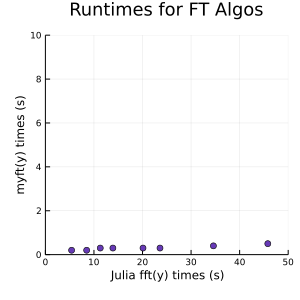

In [24]:
plot(mytimes, ffttimes, seriestype = :scatter,
    label=false, color = purples[4], 
    size = (300,300),
    title="Runtimes for FT Algos", xlabel = "Julia fft(y) times (s)", ylabel = "myft(y) times (s)",
    titlefontsize = 12, xguidefontsize = 8, yguidefontsize = 8, tickfontsize = 6,
    xlim = (0.0, 50), ylim = (0.0, 10)
)

Observe that the Julia `fft(y)` runtime hardly climbs at all

#### 2e. Synthesizing bandpass noise

My best guess as to what to do is to create the fourier matrix for a short noise signal  $y$, make a bunch of the lower- and higher-$k$ columns either $I$ or $0$ columns, transform $y \rightarrow s$ with that matrix, `ifft` it back to $y$ and have a listen:

In [25]:
y, t = createnoise(noisetype="Gaussian", duration=0.25, filename="original_noise.wav", createfile=false, playfile=true);

Signal Power: 0.010301736184773317
Distribution clipped? false


In [26]:
# Getting the matrix:
A = fourier_matrix(length(y));

In [27]:
# making the extreme columns into the identity
lbound = (2/10)*length(y)
ubound = (4/10)*length(y)
for row = 1:length(y)
    for col = 1:length(y)
        if (row <= lbound) || (row > ubound)
            if(row == col)
                A[row, col] = 1 + 0im
            else
                A[row, col] = 0 + 0im
            end
        end
    end
end

In [28]:
s = A*y
y = ifft(s)
y = real(y)
wavplay(y, 44100)

Eh.. it kind of works.  Played around with bounds, and it definitely filters the noise.  I did, however, have to get rid of (make into rows of $I$) rows instead of columns, like I originally predicted.  Why that is, I don't exactly get, because I would think you'd be wanting to destroy the ability of certain frequencies to come back.  Puzzling.

### 3. Transforms in 2D

My best guess is that some of the bases images will have be sinusoids traversing across the image, going from $0$ to $N$ periods, and that some will have the same but it a $90^{\circ}$-rotatated orientation.

And since it is made of cosines, my best guess is something approximately like this:

$$w_{kj}[n,m]=cos(\omega_k n) + cos(\omega_j m) = cos(\frac{2\pi k n}{N}) + cos(\frac{2\pi j m}{N})$$

normalized somehow

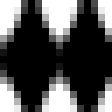

In [29]:
img = Gray.(make2Dcell(1,2,16))

In [30]:
N = 16
images = zeros(Float64, (N,N,(N*N)))
for k = 1:N
    for j = 1:N
        idx = ((k-1)*N)+j
        images[:, :, idx] = Gray.(make2Dcell(k-1,j-1,N))
    end
end

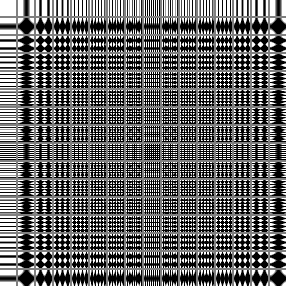

In [31]:
Gray.(mosaicview(images; fillvalue=0.5, npad=2, ncol=N, rowmajor=true))